In [1]:
!pip install git+https://github.com/takuseno/d4rl-atari

# ACHTUNG You will get an error but don't worry. Press the button 'restart session' and run this cell again

  Cloning https://github.com/takuseno/d4rl-atari to /tmp/pip-req-build-2xmrmw38
  Running command git clone --filter=blob:none --quiet https://github.com/takuseno/d4rl-atari /tmp/pip-req-build-2xmrmw38
  Resolved https://github.com/takuseno/d4rl-atari to commit 039d1a935ca932b916c544feaa63b9b6ae73e293
  Preparing metadata (setup.py) ... done


In [2]:
# TODO maybe it's not necessary
!pip install gym[atari]
!pip install autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=75409d4538adedabbad4f3cbf6550b958fc3b4a37c35aacdea74f3d093e375aa
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


## DECISION TRANSFORMER
A new class that inherits from  GPT2 model but modifying the input and output to work with sequences of actions, states and returns-to-go.

inspired in
https://github.com/kzl/decision-transformer

A modification of the Hugging Face transformer.
look at: gym/decision_transformer/decision_transformer.py


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import math
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Transformer architecture

<p align="center">
<img src="https://lilianweng.github.io/lil-log/assets/images/transformer.png" width="1000px" alt="Zoom in to the Transformer"/>
</p>

## ATTENTION

In [47]:
# default GPT2 values?
hparams = {
    'n_layer':6, # num of blocks?
    'n_head': 8, #
    'n_embd':128,
    'context_length':30,
    'block_size':90, # context_length * 3
    'dropout':0.1, # dropout value
    'bias': True, # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster. warning! nn.LayerNorm doesn't support bias=False
    'vocab_size':4, # in breakout, 6 in Pong
    'batch_size': 2,
    'model_type':'reward_conditioned',
    'num_workers': 4,
    'max_timesteps': 2654,
    'path': '/content/',
}

In [48]:
class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention
    """

    def __init__(self):
        super().__init__()

        self.n_embd = hparams['n_embd'] # embeding dimensionality, includes all heads
        self.n_head = hparams['n_head'] #  num heads
        self.block_size = hparams['block_size']
        assert self.n_embd % self.n_head == 0

        # key, query, value projections for all heads, but in a batch
        self.key = nn.Linear(self.n_embd, self.n_embd, bias=hparams['bias'])
        self.query = nn.Linear(self.n_embd, self.n_embd, bias=hparams['bias'])
        self.value = nn.Linear(self.n_embd, self.n_embd, bias=hparams['bias'])

        # regularization
        self.attn_drop = nn.Dropout(hparams['dropout'])
        self.resid_drop = nn.Dropout(hparams['dropout'])

        # output projection
        self.proj = nn.Linear(self.n_embd, self.n_embd, bias=hparams['bias'])

        # causal mask to ensure that attention is only applied to the left in the input sequence
        # every token only comunicates with the previous ones
        # This is typically used to register a buffer that should not to be considered a model parameter.
        # creates -> self.mask
        #self.register_buffer("mask", torch.tril(torch.ones(self.block_size, self.block_size))
        #                             .view(1, 1, self.block_size, self.block_size))
        self.register_buffer("mask", torch.tril(torch.ones(self.block_size + 1, self.block_size + 1))
                                     .view(1, 1, self.block_size + 1, self.block_size + 1))

        #self._reset_parameters() # uncomment if we need to initialize as the original transformer

    def _reset_parameters(self):
        # Original Transformer initialization
        nn.init.xavier_uniform_(self.c_attn.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        self.c_attn.bias.data.fill_(0)
        self.proj.bias.data.fill_(0)


    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        head_size = self.n_head, C // self.n_head

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, seqLen, numHeads, headSize) -> (B, numHeads, seqLen, headSize)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, numHeads, seqLen, headSize) x (B, numHeads, headSize, seqLen) -> (B, numHeads, seqLen, seqLen)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf')) # aplying the softmax -inf become 0
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.proj(y)
        y = self.resid_drop(y)
        return y

##MLP

In [49]:
class GPT2MLP(nn.Module):

    def __init__(self):
        super().__init__()

        self.n_embd = hparams['n_embd']

        self.c_fc    = nn.Linear(self.n_embd, 4 * self.n_embd, bias=hparams['bias']) # expand to dim*4
        self.act    = nn.GELU()
        self.c_proj  = nn.Linear(4 * self.n_embd, self.n_embd, bias=hparams['bias'])
        self.dropout = nn.Dropout(hparams['dropout'])

    def forward(self, x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

##BLOCK


<p align="center">
<img src="https://www.researchgate.net/publication/365625866/figure/fig2/AS:11431281098698218@1669051398448/Structure-of-the-applied-GPT-2-medium-architecture_W640.jpg" width="280px" alt="Zoom in to the Transformer"/>
</p>


In [50]:
class Block(nn.Module):

    def __init__(self):
        super().__init__()

        self.n_embd = hparams['n_embd']

        self.ln1 = nn.LayerNorm(self.n_embd, bias=hparams['bias'])
        self.ln2 = nn.LayerNorm(self.n_embd, bias=hparams['bias'])
        self.attn = CausalSelfAttention()
        #self.mlp = GPT2MLP()
        self.mlp = nn.Sequential(
          nn.Linear(self.n_embd, 4 * self.n_embd, bias=hparams['bias']), # expand to dim*4
          nn.GELU(),
          nn.Linear(4 * self.n_embd, self.n_embd, bias=hparams['bias']),
          nn.Dropout(hparams['dropout'])
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x)) # LayerNorm -> attention -> Add ???? no hauria de layerNOrm després de l'attention?
        x = x + self.mlp(self.ln2(x)) # like x = self.ln_2(x + self.mlp(x))
        return x

##TRANSFORMER style GTP2

https://d2l.ai/_images/vit.svg

In [51]:
class GPT(nn.Module):
    """ GPT Language Model """

    def __init__(self, max_timestep):
        super().__init__()

        self.block_size = hparams['block_size']
        self.vocab_size = hparams['vocab_size']
        self.n_embd = hparams['n_embd']
        self.model_type = hparams['model_type']
        self.max_timestep = max_timestep

        # input embedding stem
        self.tok_emb = nn.Embedding(self.vocab_size, self.n_embd)  # n_embd includes all heads -> tok embedding
        # self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.pos_emb = nn.Parameter(torch.zeros(1, self.block_size + 1, self.n_embd))
        self.global_pos_emb = nn.Parameter(torch.zeros(1, self.max_timestep+1, self.n_embd))
        self.drop = nn.Dropout(hparams['dropout'])

        # transformer
        #self.blocks = nn.ModuleList([GPT2Block() for _ in range(hparams['n_layer'])])
        self.blocks = nn.Sequential(*[Block() for _ in range(hparams['n_layer'])])

        # decoder head
        self.ln_f = nn.LayerNorm(self.n_embd)

        # out linear
        self.head = nn.Linear(self.n_embd, self.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)

        # STATE encoding
        self.state_encoder = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4, padding=0), # stack 4 frames -> 4 channel in
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, self.n_embd),
            nn.Tanh())

        # RETURN embedding
        self.ret_emb = nn.Sequential(
            nn.Linear(1, self.n_embd),
            nn.Tanh())

        # ACTION embedding
        self.action_embeddings = nn.Sequential(
            nn.Embedding(self.vocab_size, self.n_embd),
            nn.Tanh())
        # initialization
        nn.init.normal_(self.action_embeddings[0].weight, mean=0.0, std=0.02)


        # report number of parameters
        n_params = sum(p.numel() for p in self.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))


    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    # state, action, and return
    def forward(self, states, actions, targets=None, rtgs=None, timesteps=None):
        # states: (batch, block_size, 4*84*84)
        # actions: (batch, block_size, 1)
        # targets: (batch, block_size, 1)
        # rtgs: (batch, block_size, 1)
        # timesteps: (batch, 1, 1)
        #batch_size = states.shape[0]


        # PLAN:
        # 1. Compute embeddings for tokens
        # pos_embedding = embed_t(t) # per-timestep (note: not per-token)
        # s_embedding = embed_s(s) + pos_embedding
        # a_embedding = embed_s(a) + pos_embedding
        # R_embedding = embed_R(R) + pos_embedding

        # STATE embedding
        # TODO STACK*4 i gestionar blocks de 4 imatges x capturar moviment
        state_embeddings = self.state_encoder(states.reshape(-1, 4, 84, 84).type(torch.float32).contiguous()) # (batch * block_size, n_embd)

        #state_embeddings = self.state_encoder(states) # (batch * block_size, n_embd)
        state_embeddings = state_embeddings.reshape(states.shape[0], states.shape[1], self.n_embd) # (batch, block_size, n_embd)

        # create tokens
        if actions is not None and self.model_type == 'reward_conditioned':
            # RETURN & ACTION embeddings
            rtg_embeddings = self.ret_emb(rtgs.type(torch.float32))
            action_embeddings = self.action_embeddings(actions.type(torch.long).squeeze(-1)) # (batch, block_size, n_embd)

            # token_embeddings inclou els 3 embeddings
            token_embeddings = torch.zeros((states.shape[0], states.shape[1]*3 - int(targets is None), self.n_embd), dtype=torch.float32, device=state_embeddings.device)
            token_embeddings[:,::3,:] = rtg_embeddings
            token_embeddings[:,1::3,:] = state_embeddings
            token_embeddings[:,2::3,:] = action_embeddings[:,-states.shape[1] + int(targets is None):,:]
        elif actions is None and self.model_type == 'reward_conditioned': # only happens at very first timestep of evaluation
            rtg_embeddings = self.ret_emb(rtgs.type(torch.float32))

            token_embeddings = torch.zeros((states.shape[0], states.shape[1]*2, self.n_embd), dtype=torch.float32, device=state_embeddings.device)
            token_embeddings[:,::2,:] = rtg_embeddings # really just [:,0,:]
            token_embeddings[:,1::2,:] = state_embeddings # really just [:,1,:]
        elif actions is not None and self.model_type == 'naive':
            action_embeddings = self.action_embeddings(actions.type(torch.long).squeeze(-1)) # (batch, block_size, n_embd)

            token_embeddings = torch.zeros((states.shape[0], states.shape[1]*2 - int(targets is None), self.n_embd), dtype=torch.float32, device=state_embeddings.device)
            token_embeddings[:,::2,:] = state_embeddings
            token_embeddings[:,1::2,:] = action_embeddings[:,-states.shape[1] + int(targets is None):,:]
        elif actions is None and self.model_type == 'naive': # only happens at very first timestep of evaluation
            token_embeddings = state_embeddings
        else:
            raise NotImplementedError()

        # 2. interleave tokens as (R_1,s_1, a_1, ...., R_K, s_K)
        # input_embeds = stack (R_embedding, s_embedding, a_embeding)
        # position embeddings of shape (1, t=seq_len, n_embd)

        all_global_pos_emb = torch.repeat_interleave(self.global_pos_emb, hparams['batch_size'], dim=0) # batch_size, traj_length, n_embd
        position_embeddings = torch.gather(all_global_pos_emb, 1, torch.repeat_interleave(timesteps, self.n_embd, dim=-1)) + self.pos_emb[:, :token_embeddings.shape[1], :]


        # 3. use transformer to get hidden states
        # hidden_states = transformer(input_embeds=input_embeds)

        # forward the GPT model itself
        # token embeddings of shape (b, t=seq_len, n_embd)
        # position embeddings of shape (1, t=seq_len, n_embd)
        # 1 position embedding for every 3 tokens
        x = self.drop(token_embeddings + position_embeddings)

        x = self.blocks(x)

        # 4. select hidden states for action prediction tokens
        # a_hidden = unstack(hidden_states).actions
        x = self.ln_f(x)
        logits = self.head(x)

        if actions is not None and self.model_type == 'reward_conditioned':
            logits = logits[:, 1::3, :] # only keep predictions from state_embeddings
        elif actions is None and self.model_type == 'reward_conditioned':
            logits = logits[:, 1:, :]
        elif actions is not None and self.model_type == 'naive':
            logits = logits[:, ::2, :] # only keep predictions from state_embeddings
        elif actions is None and self.model_type == 'naive':
            logits = logits # for completeness
        else:
            raise NotImplementedError()

        # if we are given some desired targets also calculate the loss
        #Atari -> discrete actions -> logits = probability of different classes -> loss = cross entropy
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1).long())

        # 5. predict action
        # return pred_a(a_hidden)
        return logits, loss



#SET THE ENVIRONMENT

In [9]:
import gym
import d4rl_atari
# TODO triar l'expert
env = gym.make('breakout-mixed-v4', stack=True) # 4 stacked gray-scale images


obsservation_0 = env.reset() # (4, 84, 84)



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `re

# SETUP THE DATASET

In [10]:

def create_dataset():

      # GET THE DATA !!
      dataset = env.get_dataset()

      obs_data = dataset['observations'] # observation data in (1000000, 1, 84, 84)
      action_data = dataset['actions'] # action data in (1000000,)
      reward_data = dataset['rewards'] # reward data in (1000000,)
      terminal_data = dataset['terminals'] # terminal flags in (1000000,)

      plt.imshow(obs_data[1000][0])
      plt.show()
      print('action_data ', action_data.shape)

      terminal_pos = np.where(terminal_data==1)[0]
      terminal_data = None # de-allocate mem
      print("num episodes ", terminal_pos.shape)

      # -- create reward-to-go dataset
      start_index = 0
      rtg = np.zeros_like(reward_data)
      for i in terminal_pos:
          curr_traj_returns = reward_data[start_index:i]
          reward_acum = 0
          for j in range(i-1, start_index-1, -1): # start from i-1
              reward_acum += reward_data[j]
              #rtg_j = curr_traj_returns[j-start_index:i-start_index]
              rtg[j] = reward_acum
          start_index = i
      print('max rtg is %d' % max(rtg))

      reward_data = None

      # -- create timestep dataset ******************************
      start_index = 0
      timesteps = np.zeros(len(action_data), dtype=int)
      for i in terminal_pos:
          timesteps[start_index:i] = np.arange(i - start_index)
          start_index = i

      max_timestep = max(timesteps)
      print('max timestep is %d' % max_timestep)
      print("***** data loaded **********")

      print('action possible numbers: ', np.unique(action_data))
      assert hparams['vocab_size'] == len(np.unique(action_data)), "hparams['vocab_size'] should be the number of possible action values"

      return obs_data, action_data, terminal_pos, rtg, timesteps, max_timestep



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Class that picks up a block of data from the dataset
class StateActionReturnDataset(Dataset):

    def __init__(self, data, actions, done_idxs, rtgs, timesteps):
        self.block_size = hparams['block_size'] // 3
        self.data = data
        self.actions = actions
        self.done_idxs = done_idxs
        self.rtgs = rtgs
        self.timesteps = timesteps

    def __len__(self):
        return len(self.data) - self.block_size * 3

    def __getitem__(self, idx):
        block_size = self.block_size
        # to avoid blocks in between of 2 trajectories, if the idx is too close to the end of a trajectory, re-position
        # the idx to a block_size away to the end of the trajectory
        done_idx = idx + block_size
        for i in self.done_idxs:
            if i > idx: # first done_idx greater than idx
                done_idx = min(int(i), done_idx)
                break
        idx = done_idx - block_size
        states = torch.tensor(np.array(self.data[idx:done_idx]), dtype=torch.float32).reshape(block_size, -1) # (block_size, 4*84*84)
        states = states / 255. # normalize data
        actions = torch.tensor(self.actions[idx:done_idx], dtype=torch.long).unsqueeze(1) # (block_size, 1)
        rtgs = torch.tensor(self.rtgs[idx:done_idx], dtype=torch.float32).unsqueeze(1)
        timesteps = torch.tensor(self.timesteps[idx:idx+1], dtype=torch.int64).unsqueeze(1) # (1,1) it takes only 1 timestep to represent all the block

        return states, actions, rtgs, timesteps

#TRAINING

In [13]:
# TRAINING PARAMS
tparams = {
    'max_epochs':10,
    'learning_rate':3e-4,
    'betas':(0.9, 0.95),
    'grad_norm_clip':1.0, #??????
    #'weight_decay':0.1, # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    #'lr_decay':False,
    #'warmup_tokens':375e6, # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    #final_tokens = 260e9 # (at what point we reach 10% of original LR)
}

In [14]:
from tqdm import tqdm

def trainer(model, dataloader):

        optimizer = torch.optim.AdamW(model.parameters(), lr=tparams['learning_rate'], betas=tparams['betas'])
        lr = tparams['learning_rate']

        #self.tokens = 0 # counter used for learning rate decay

        for epoch in range(tparams['max_epochs']):

            model.to(device)
            model.train()

            loader = DataLoader(dataloader, shuffle=True, pin_memory=True, # pin_memory ???????
                                batch_size=hparams['batch_size'],
                                num_workers=hparams['num_workers'])

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader))
            for it, (obs, act, rtg, ts) in pbar:

                # place data on the correct device
                obs = obs.to(device) # size([B, seq_len, 28224])
                act = act.to(device) # size([B, seq_len, 1])
                rtg = rtg.to(device) # size([B, seq_len, 1])
                ts = ts.to(device) #   size([B, 1, 1])

                # forward the model
                #with torch.set_grad_enabled(True):
                logits, loss = model(obs, act, act, rtg, ts)
                loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                losses.append(loss.item())

                # backprop and update the parameters
                model.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), tparams['grad_norm_clip']) # ?????????????
                optimizer.step()

                    # decay the learning rate based on our progress
                    #if config.lr_decay:
                    #    self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                    #    if self.tokens < config.warmup_tokens:
                    #        # linear warmup
                    #        lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                    #    else:
                    #        # cosine learning rate decay
                    #        progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                    #        lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                    #    lr = config.learning_rate * lr_mult
                    #    for param_group in optimizer.param_groups:
                    #        param_group['lr'] = lr
                    #else:
                    #    lr = config.learning_rate

                    # report progress
                pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")


loading /root/.d4rl/datasets/Breakout/5/1/observation.gz...
loading /root/.d4rl/datasets/Breakout/5/1/action.gz...
loading /root/.d4rl/datasets/Breakout/5/1/reward.gz...
loading /root/.d4rl/datasets/Breakout/5/1/terminal.gz...


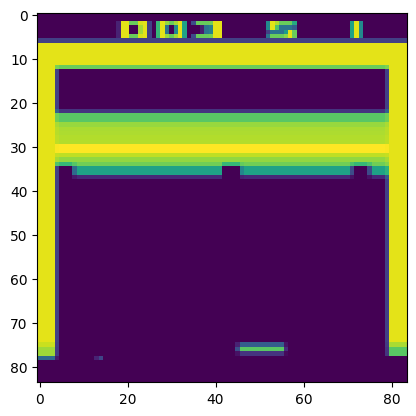

action_data  (1000000,)
num episodes  (1824,)
max rtg is 32
max timestep is 1243
***** data loaded **********
action possible numbers:  [0 1 2 3]


In [12]:
# CREATE THE DATASET
obss, actions, done_idxs, rtgs, timesteps, maxTimestep = create_dataset()
hparams['max_timesteps'] = maxTimestep

# CREATE A CLASS FOR THE DATALOADER TO GET DATA
train_dataset = StateActionReturnDataset(obss, actions, done_idxs, rtgs, timesteps)


In [ ]:
#print(done_idxs)
#print(rtg[:1000])
#print(timesteps[:1000])

In [58]:
# CREATE THE MODEL
# maxTimestep = max steps in a trajectory
model_gpt = GPT(hparams['max_timesteps'])
model_gpt.to(device)
model_gpt

number of parameters: 2.02M


GPT(
  (tok_emb): Embedding(4, 128)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=128, out_features=128, bias=True)
        (query): Linear(in_features=128, out_features=128, bias=True)
        (value): Linear(in_features=128, out_features=128, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affin

In [13]:
# TRAIN THE MODEL
trainer(model_gpt, train_dataset)


number of parameters: 3.03M


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'trainer' is not defined

#EVALUATION




In [ ]:
# evaluation loop
#target_return = 1 # for instance, expert-level return
#R,s,a,t, done = `target_return], [env.reset()], [], [1], False
#while not done: # autoregressive generation/sampling
  # sample next action
  #action = DecisionTransformer(R,s,a,t) [-1] # for cta actions
  #new_s,r,done,_ = env.step(action)

  # append new tokens to sequence
  #R = R + [R[-1] - r] # decrease returns-to-go with reward
  #s,q,t = s + [new_s], a +[action], t + [len(R)]
  #R,s,a,t = R[-K:], ... # only keep context length of K

In [59]:
def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None, actions=None, rtgs=None, timesteps=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = hparams['batch_size']
    model.eval()
    for k in range(steps):
        # x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        x_cond = x if x.size(1) <= block_size//3 else x[:, -block_size//3:] # crop context if needed
        if actions is not None:
            actions = actions if actions.size(1) <= block_size//3 else actions[:, -block_size//3:] # crop context if needed
        rtgs = rtgs if rtgs.size(1) <= block_size//3 else rtgs[:, -block_size//3:] # crop context if needed

        logits, _ = model(x_cond, actions=actions, targets=None, rtgs=rtgs, timesteps=timesteps)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        # x = torch.cat((x, ix), dim=1)
        x = ix

    return x

In [60]:
def get_returns(ret, model):

        model = model
        model.eval() # for inference
        #model.train(False)

        T_rewards = []
        done = True
        for i in range(10): # it will output 10 eval returns
            state = env.reset()
            #print('***************** get_return ******************')
            #print('state ', state.shape)
            state = torch.Tensor(state)
            state = state.to(device).unsqueeze(0).unsqueeze(0)
            rtgs = [ret]
            #print('ret ', ret)
            #print('state ', state.shape)
            # first state is from env, first rtg is target return, and first timestep is 0
            sampled_action = sample(model, state, 1, temperature=1.0, sample=True, actions=None,
                rtgs=torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1),
                timesteps=torch.zeros((1, 1, 1), dtype=torch.int64).to(device))

            j = 0
            all_states = state
            actions = []
            while True:
                if done:
                    state, reward_sum, done = env.reset(), 0, False
                    state = torch.Tensor(state)
                    reward_sum = torch.Tensor(reward_sum)
                action = sampled_action.cpu().numpy()[0,-1]
                actions += [sampled_action]
                state, reward, done, _= env.step(action)
                state = torch.Tensor(state)

                #reward = torch.Tensor(reward)
                reward_sum += reward
                j += 1

                if done:
                    T_rewards.append(reward_sum)
                    #print(reward_sum)
                    break

                state = state.unsqueeze(0).unsqueeze(0).to(device)

                all_states = torch.cat([all_states, state], dim=0)

                rtgs += [rtgs[-1] - reward]
                # all_states has all previous states and rtgs has all previous rtgs (will be cut to block_size in utils.sample)
                # timestep is just current timestep
                sampled_action = sample(model, all_states.unsqueeze(0), 1, temperature=1.0, sample=True,
                    actions=torch.tensor(actions, dtype=torch.long).to(device).unsqueeze(1).unsqueeze(0),
                    rtgs=torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1),
                    timesteps=(min(j, hparams['max_timesteps']) * torch.ones((1, 1, 1), dtype=torch.int64).to(device)))
        #env.close()
        eval_return = sum(T_rewards)/10.
        print('target return ',ret)

        return eval_return

In [61]:
#trainer = Trainer(model, train_dataset, None, tconf)
eval_return = get_returns(90, model_gpt)
print('eval_return ', eval_return)

#'naive': get_returns(0)
#'reward_conditioned':
#'Breakout': get_returns(90)
#'Seaquest': get_returns(1150)
#'Qbert': get_returns(14000)
#'Pong': get_returns(20)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'gym.wrappers.frame_stack.LazyFrames'>
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:226: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


target return  90
eval_return  tensor([])


# EXTRA

In [ ]:
%load_ext tensorboard
%tensorboard --logdir training/logs

# SAVE CHECKPOINTS

In [ ]:
# SAVE MODEL
torch.save(model_gpt, hparams['path'])

# LOAD CHECKPOINTS

In [65]:
# DOWNLOAD CHECKPOINTS
!gdown "https://drive.google.com/uc?id=1ug0o5v2UlNjuLhJp_vDUMvWX32uUjdAy" # Breakout_123
#!gdown "https://drive.google.com/uc?id=1PFwBV8XJlGcCPxwRMh4Dco2gkdz-Ep-c" # QBert_123
#!gdown "https://drive.google.com/uc?id=14CJP2aAKsIMmlzBLAMDxLLBGHlnJF71N" # Seaquest_123


Downloading...
From: https://drive.google.com/uc?id=1ug0o5v2UlNjuLhJp_vDUMvWX32uUjdAy
To: /content/Breakout_123.pth
100% 8.33M/8.33M [00:00<00:00, 18.2MB/s]


In [66]:
# LOAD SAVED CHECKPOINTS
checkpoint = torch.load('/content/Breakout_123.pth')
model_gpt.load_state_dict(checkpoint)


<All keys matched successfully>